In [2]:
import deepcut
from deepcut import DeepcutTokenizer
import sys
import pandas as pd
import numpy as np
import math
import json
import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from keras.preprocessing.text import Tokenizer 
from neo4j import GraphDatabase
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [64]:
pd.set_option('display.max_columns',None)
n = 0
arr_category = []
arr_details = []
data = pd.DataFrame(columns=['id','detail','category'])
#display(data)
for category in ['crime','politic','world']:
    for i in glob.glob("../data/sanook1/" + category +"/*/content.txt")[:10]:
        #print(i)
        news_id = i.split("/")[-2]
        dftmp = pd.read_csv(i,names='c')
        #display(dftmp)
        arr_tmp = dftmp['c'].values
        result = ' '.join(map(str,(arr_tmp)))
        data = data.append({"id":news_id,"detail":result,"category":category},ignore_index=True)
display(data)

id                                             detail category
0   7766894  ศาลฎีกาเคาะไม่อนุญาตให้ประกันตัว "เสี่ยเบนซ์ชน...    crime
1   7786646  ชุดสืบเมืองตรังพลิกแผ่นดินตามจับ ผู้ต้องหาฆ่าเ...    crime
2   7769642                                                 dc    crime
3   7759478  นายอำนาจ อินสุวรรณโณ หรือ บอลใต้ ผู้ต้องหาตามห...    crime
4   7747770                                                 dc    crime
5   7754155  เมื่อเวลา 15.00 น. (25 เม.ย. 62) ร.ต.อ.สง่า สม...    crime
6   7814490  (24 มิ.ย.62)  ผู้สื่อข่าวรายงานว่าจากกรณีที่เจ...    crime
7   7805186  ควาญช้างกระหน่ำยิง 3 นัดซ้อนใส่เมียสาวขาดใจตาย...    crime
8   7713666  หวิดเป็นโศกนาฏกรรม ครูสาวตั้งระบบจีพีเอสนำทาง ...    crime
9   7743778  พบศพลอยน้ำหลังวัดสร้อยทอง ตำรวจ สน.บางโพ รุดตร...    crime
10  7773922  วันนี้ (17 พ.ค. 62) นายเทพไท เสนพงศ์ ส.ส.นครศร...  politic
11  7673098  พรรคไทยรักษาชาติ (ทษช.) ยื่นพระนามทูลกระหม่อมห...  politic
12  7738226  8 เม.ย.62 -  ที่พรรคประชาธิปัตย์ นายสมชัย ศรีส...  politic
13  7768790  รายงานข่าวจากพรรคพลังประชารัฐเผยว่า ประเด็นที่...  politic
14  7803418  นายสนธิรัตน์ สนธิจิรวงศ์ เลขาธิการพรรคพลังประช...  politic
15  7730074  ศึกชิงหัวหน้าพรรคประชาธิปัตย์เริ่มชัดเจน หลัง ...  politic
16  7785498  นายกรัฐมนตรี เข้าทำเนียบฯ ก่อนที่ ผบ.ทบ. จะเข้...  politic
17  7735734  นายปกรณ์ มหรรณพ พร้อมด้วย นายฐิติเชฏฐ์ นุชนาฏ ...  politic
18  7703090  7 มี.ค. 62 - ผู้สื่อข่าวรายงานว่า เมื่อเวลา 14...  politic
19  7815770  26 มิ.ย. 62 - พล.ต.อ.เสรีพิศุทธ์ เตมียเวส หัวห...  politic
20  7704870  พื้นที่ส่วนใหญ่ของเวเนซุเอลาตกอยู่ในความมืดตั้...    world
21  7728286  เขตปกครองร็อคแลนด์ เคาน์ตี้ ในรัฐนิวยอร์ก ประก...    world
22  7807870  000 นาย พร้อมเปิดภาพใหม่เป็นหลักฐานมัดอิหร่านว...    world
23  7678642  ระทึก รถไฟเหาะสวนสนุกในจีนพุ่งตกรางครึ่งคัน เด...    world
24  7739790  ศาลฮ่องกงพิพากษาเมื่อวันอังคารว่า 9 แกนนำขบวนก...    world
25  7813814  หัวร้อน! นักช็อปชาวจีนเปิดศึกทะเลาะกันหน้าร้าน...    world
26  7776498                                                 dc    world
27  7689318  สาวนิวซีแลนด์รู้สึกเจ็บและระคายเคืองข้างในหูมา...    world
28  7735350  ทางการอินโดนีเซียจะสั่งปิดเกาะโคโมโด แหล่งที่อ...    world
29  7747542  สกัดเหตุซ้ำรอยไฟไหม้วิหารน็อทร์-ดาม ตำรวจนิวยอ...    world

In [65]:
def CheckNull(x):
    if pd.isnull(x):
        x = "Unknow"
    return x


data['detail'] = data['detail'].apply(CheckNull)
data.isnull().any()
data.count()

id          30
detail      30
category    30
dtype: int64

In [32]:
#ใช้สำหรับ merge data category  convert data 
#detail = []
#ntype = []
#for i in news_type:
#    arr_text = data[data['id'] == i]['detail'].values
#    text = " ".join(arr_text)
#    detail.append(text)
#    ntype.append(i)

#data2 = pd.DataFrame.from_dict({'detail':detail,'category':ntype})
#data_ori = data
#data = data2

#data

In [66]:
#convert data 
data[data['category'] == 'politic'].tail()

id                                             detail category
15  7730074  ศึกชิงหัวหน้าพรรคประชาธิปัตย์เริ่มชัดเจน หลัง ...  politic
16  7785498  นายกรัฐมนตรี เข้าทำเนียบฯ ก่อนที่ ผบ.ทบ. จะเข้...  politic
17  7735734  นายปกรณ์ มหรรณพ พร้อมด้วย นายฐิติเชฏฐ์ นุชนาฏ ...  politic
18  7703090  7 มี.ค. 62 - ผู้สื่อข่าวรายงานว่า เมื่อเวลา 14...  politic
19  7815770  26 มิ.ย. 62 - พล.ต.อ.เสรีพิศุทธ์ เตมียเวส หัวห...  politic

In [67]:
#Deepcut
tokenizer = DeepcutTokenizer(ngram_range=(1,1),max_df=1.0, min_df=0.0)

In [68]:
#Take time half a minute
series_detail = data['detail']
tfidf_matrix = tokenizer.fit_tranform(series_detail)

In [69]:
#Defined TF
tflog = 0
tfidfvocab = pd.DataFrame()
tmp_total_cat = {}
tfidfvocab['key'] = list(tokenizer.vocabulary_.keys())
tfidfvocab['df'] = np.zeros(len(tokenizer.vocabulary_.keys()))
for  i in news_type:
    tfidfvocab['cat_'+str(i)] = np.zeros(tfidfvocab['key'].count())
    tmp_total_cat[i] = len(data[data['category'] == i].values)
    
for k,i in series_detail.iteritems():
    #print(k,i)
    freq = "f_"+str(data['id'][k])
    tf = "tf_"+str(data['id'][k])
    cat = "cat_"+str(data['category'][k])
    tmp1 = np.zeros(tfidfvocab['key'].count())
    tmp=tfidf_matrix[k]
    arr_indices=tmp.indices
    arr_data = tmp.data
    for j in range(len(arr_indices)):
        index = arr_indices[j]
        tmp1[index] = arr_data[j] #calculate from tokenizer
    tfidfvocab[freq] = tmp1
    tfidfvocab['df'] = tfidfvocab['df']+tfidfvocab[freq].apply(lambda x: 1 if x > 0 else 0)
    tfidfvocab[cat] = tfidfvocab[cat]+tfidfvocab[freq].apply(lambda x: 1 if x > 0 else 0)
    totalWordInDoc1=tfidfvocab[tfidfvocab[freq] > 0]['key'].count()
    if tflog:
        tfidfvocab[tf] = 1 + np.log(tfidfvocab[freq]/totalWordInDoc1)
    else:
        tfidfvocab[tf] = tfidfvocab[freq]/totalWordInDoc1
    
for  i in news_type:
    tfidfvocab['cat_'+str(i)] = tfidfvocab[cat]/tmp_total_cat[i]

    
#tfidfvocab.sort_values('tf_7769630',ascending=0).head()
#tmp_total_cat

In [72]:
tfidfvocab = tfidfvocab[tfidfvocab['key'] != '']
tfidfvocab = tfidfvocab[tfidfvocab['key'] != ' ']
print(len(tfidfvocab))
tfidfvocab[['tf_7730074','key','df']].sort_values('tf_7730074',ascending=0).head(10)

1772


tf_7730074      key    df
1382    0.075472        "   9.0
59      0.066038      ที่  27.0
858     0.066038  หัวหน้า   5.0
1742    0.047170       มี  25.0
1334    0.047170     พรรค   7.0
1478    0.037736  ตำแหน่ง   4.0
1324    0.037736       คน  20.0
910     0.037736      ว่า  26.0
326     0.037736      การ  24.0
1736    0.037736      จาก  26.0

In [73]:
#Defined IDF
totalDocument = len(data)
#print(totalDocument)
tfidfvocab['idf'] = np.log((totalDocument+1)/(tfidfvocab['df']+1))+1
#tfidfvocab['idf'] = (totalDocument+1)/tfidfvocab['df']
tfidfvocab[['key','idf','df']].sort_values('idf',ascending=0).head(10)

key      idf   df
887          35  3.74084  1.0
1037         58  3.74084  1.0
1049  สาธารณสุข  3.74084  1.0
1048    อาจารย์  3.74084  1.0
1047        ยุค  3.74084  1.0
1045       เซ็น  3.74084  1.0
1044      เฉพาะ  3.74084  1.0
1041       คบหา  3.74084  1.0
1040       เพีย  3.74084  1.0
1038         บก  3.74084  1.0

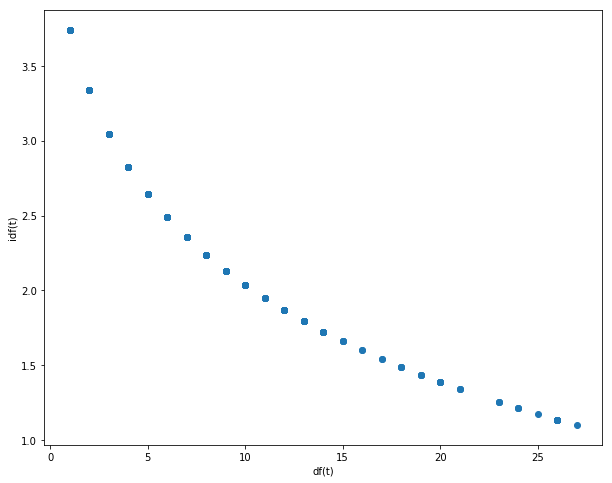

In [74]:
#plt.xlabel('df(t)')
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.xlabel('df(t)')
plt.ylabel('idf(t)')
plt.plot(tfidfvocab['df'],tfidfvocab['idf'],'o')

(array([   19.,    18.,    31.,    35.,    53.,    72.,    72.,   101.,
          234.,  1137.]),
 array([ 1.10178269,  1.36568843,  1.62959416,  1.89349989,  2.15740563,
         2.42131136,  2.68521709,  2.94912283,  3.21302856,  3.47693429,
         3.74084002]),
 <a list of 10 Patch objects>)

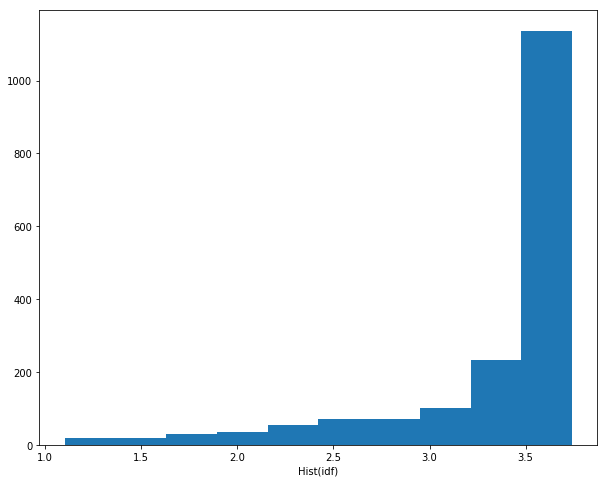

In [76]:
#histrogram idf
plt.figure(figsize=(10,8))
plt.xlabel("Hist(idf)")
plt.hist(tfidfvocab['idf'])
#a=tfidfvocab['idf']

4     0.011494
19    0.034483
43    0.011494
59    0.034483
62    0.011494
Name: tf_7743778, dtype: float64

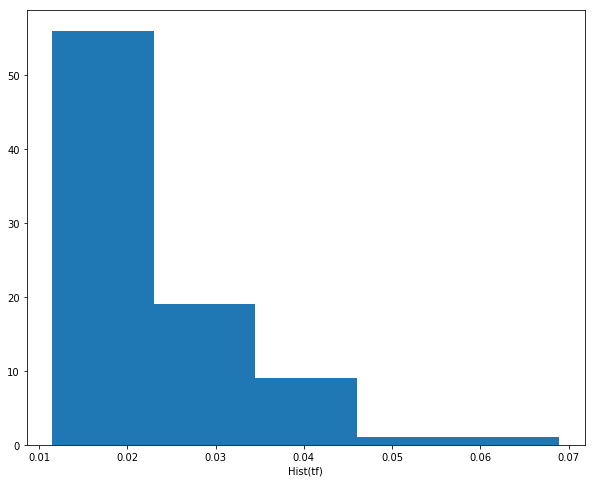

In [78]:
tfidftmp = tfidfvocab[tfidfvocab['tf_7743778'] > 0]['tf_7743778']

plt.figure(figsize=(10,8))
plt.xlabel("Hist(tf)")
plt.hist(tfidftmp,5)
tfidftmp.head()

In [79]:
#tfidf skip
for k,i in series_detail.iteritems():
    tfidf = "tfidf_"+str(data['id'][k])
    tf = "tf_"+str(data['id'][k])
    tfidfvocab[tfidf] = tfidfvocab['idf']*tfidfvocab[tf]
#tfidfvocab[['key','df','tf_politic','tfidf_politic']].sort_values('tfidf_politic',ascending=0)

In [122]:
#Options you can skip this step 
#Calculate idf with sklearn
#Take time

tokenizerOneHot = tokenizer.transform(series_detail)
tfidf_transformer = TfidfTransformer(smooth_idf=True,).fit(tokenizerOneHot)
vocabidf=tfidf_transformer.idf_.tolist()
#tfidfvocab['idf2']=vocabidf
#tfidfvocab.head()

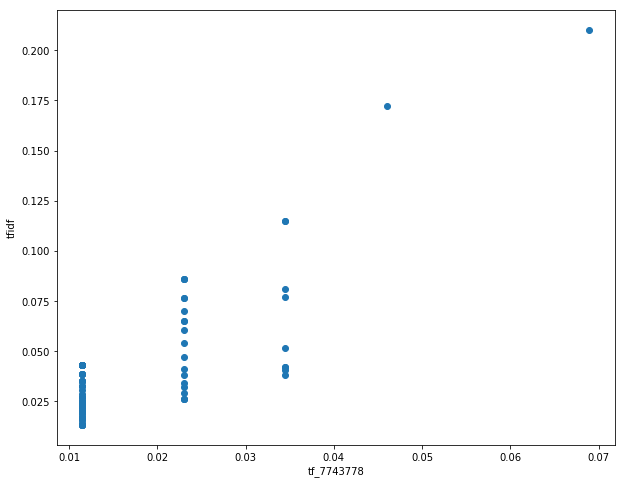

key  tfidf_tmp  f_7743778  tf_7743778       idf
1754             ศพ   0.210186        6.0    0.068966  3.047693
1439       สน.บางโพ   0.171993        4.0    0.045977  3.740840
339            อาสา   0.115013        3.0    0.034483  3.335375
1000            น้ำ   0.115013        3.0    0.034483  3.335375
1755    วัดสร้อยทอง   0.085996        2.0    0.022989  3.740840
329   ประชาสัมพันธ์   0.085996        2.0    0.022989  3.740840
304             ลอย   0.085996        2.0    0.022989  3.740840
1408        ตรวจสอบ   0.081191        3.0    0.034483  2.354546
1533    เจ้าหน้าที่   0.077130        3.0    0.034483  2.236763
1686            รอย   0.076675        2.0    0.022989  3.335375

In [80]:
#ทดสอบ Plot Graph เพื่อดูความชันของ TF-IDF
def getCategory(x):
    return data[data['id'] == x]['category'].values[0]

def tfidf(tfidfvocab,nid):
    tfidfvocab2 = tfidfvocab[tfidfvocab['key'] != ' ']
    tfidfvocab2 = tfidfvocab2[tfidfvocab2['key'] != '']
    tfidfvocab2 = tfidfvocab2[tfidfvocab2['tf_'+str(nid)] > 0]
    #tfidfvocab2['tfidf_tmp']= tfidfvocab2['idf']*tfidfvocab2['tf_'+str(nid)]*tfidfvocab2['cat_'+getCategory(nid)]
    tfidfvocab2['tfidf_tmp']= tfidfvocab2['idf']*tfidfvocab2['tf_'+str(nid)]
    #tfidfvocab2['tfidf_tmp']= tfidfvocab2['tfidf_' + str(nid)]
    plt.figure(figsize=(10,8))
    plt.xlabel('tf_'+str(nid))
    plt.ylabel('tfidf')
    tfidfvocab2 = tfidfvocab2[tfidfvocab2['tfidf_tmp'] > 0]
    plt.plot(tfidfvocab2['tf_'+str(nid)],tfidfvocab2['tfidf_tmp'],'o')
    plt.show()
    return tfidfvocab2[['key','tfidf_tmp','f_'+str(nid),'tf_'+str(nid),'idf']]

#7672498
#7671774 politic
result = tfidf(tfidfvocab,7743778)
#result.sort_values('tf_7775382',ascending=0).head(10)
result.sort_values('tfidf_tmp',ascending=0).head(10)
#รูปอธิบายว่า เส้นตรงความชันเท่ากับ 1 หมายความว่า idf = 1 ซึ่งแปลว่าปรากฏทั้ง 3 document และไม่มีนัยยะ
#แต่ความชันมากกว่า 1 แปลว่า idf > 1 ปรากฏเฉพาะบาง Document ยิ่งค่าแกน X มาก(หรือเรียกว่ามีค่า tf มาก)ยิ่งมีนัยยะ เป็นคำที่น่าสนใจและมีนัยยะ
#idf คือตัวเร่งปฏิกริยาหรือตัวคูณใช้เพิ่มความมีนัยยะให้คำค่า tf ยิ่ง tf สูง idf สูง ยิ่งค่ามีนัยยะ
#ค่า idf ต่ำสุดคือ 1 